# Tutorial: FICO Explainable Machine Learning Challenge - updating binning

In this tutorial, we extend the previous tutorial using the FICO dataset by replacing the usual binning with a piecewise continuous binning. The piecewise continuous binning uses a Gradient Boosting Tree (GBT) as an estimator.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from lightgbm import LGBMClassifier

from optbinning import BinningProcess
from optbinning import OptimalPWBinning

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

Download the dataset from the link above and load it: https://community.fico.com/s/explainable-machine-learning-challenge.

In [3]:
df = pd.read_csv("data/FICO_challenge/heloc_dataset_v1.csv", sep=",")

variable_names = list(df.columns[1:])

X = df[variable_names]

Transform the categorical dichotomic target variable into numerical.

In [4]:
y = df.RiskPerformance.values
mask = y == "Bad"
y[mask] = 1
y[~mask] = 0
y = y.astype(int)

#### Modeling

The data dictionary of this challenge includes three special values/codes:
    
* -9 No Bureau Record or No Investigation
* -8 No Usable/Valid Trades or Inquiries
* -7 Condition not Met (e.g. No Inquiries, No Delinquencies)

In [5]:
special_codes = [-9, -8, -7]

This challenge imposes monotonicity constraints with respect to the probability of a bad target for many of the variables. We apply these rules by passing the following dictionary of parameters for these variables involved.

In [6]:
binning_fit_params = {
    "ExternalRiskEstimate": {"monotonic_trend": "descending"},
    "MSinceOldestTradeOpen": {"monotonic_trend": "descending"},
    "MSinceMostRecentTradeOpen": {"monotonic_trend": "descending"},
    "AverageMInFile": {"monotonic_trend": "descending"},
    "NumSatisfactoryTrades": {"monotonic_trend": "descending"},
    "NumTrades60Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "NumTrades90Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "PercentTradesNeverDelq": {"monotonic_trend": "descending"},
    "MSinceMostRecentDelq": {"monotonic_trend": "descending"},
    "NumTradesOpeninLast12M": {"monotonic_trend": "ascending"},
    "MSinceMostRecentInqexcl7days": {"monotonic_trend": "descending"},
    "NumInqLast6M": {"monotonic_trend": "ascending"},
    "NumInqLast6Mexcl7days": {"monotonic_trend": "ascending"},
    "NetFractionRevolvingBurden": {"monotonic_trend": "ascending"},
    "NetFractionInstallBurden": {"monotonic_trend": "ascending"},
    "NumBank2NatlTradesWHighUtilization": {"monotonic_trend": "ascending"}
}

Instantiate a ``BinningProcess`` object class with variable names, special codes and dictionary of binning parameters. Choose a logistic regression as a classifier.

In [7]:
binning_process = BinningProcess(variable_names, special_codes=special_codes,
                                 binning_fit_params=binning_fit_params)

In [8]:
clf = LogisticRegression(solver="lbfgs")

Split dataset into train and test. Fit pipelines with training data, then generate classification reports to show the main classification metrics.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
binning_process.fit(X_train, y_train)

BinningProcess(binning_fit_params={'AverageMInFile': {'monotonic_trend': 'descending'},
                                   'ExternalRiskEstimate': {'monotonic_trend': 'descending'},
                                   'MSinceMostRecentDelq': {'monotonic_trend': 'descending'},
                                   'MSinceMostRecentInqexcl7days': {'monotonic_trend': 'descending'},
                                   'MSinceMostRecentTradeOpen': {'monotonic_trend': 'descending'},
                                   'MSinceOldestTradeOpen': {'mo...
                               'MaxDelq2PublicRecLast12M', 'MaxDelqEver',
                               'NumTotalTrades', 'NumTradesOpeninLast12M',
                               'PercentInstallTrades',
                               'MSinceMostRecentInqexcl7days', 'NumInqLast6M',
                               'NumInqLast6Mexcl7days',
                               'NetFractionRevolvingBurden',
                               'NetFractionInstallBurde

Now, we replace the usual binning of a few numerical variables with a piecewise continuous binning. Since version 0.9.2, the binning process includes the method ``update_binned_variable`` which allows updating an optimal binning without the need of re-processing the rest of the variables.

In [11]:
update_variables = ["ExternalRiskEstimate", "MSinceOldestTradeOpen", "PercentTradesWBalance"]

for variable in update_variables:
    optb = OptimalPWBinning(estimator=LGBMClassifier(),
                            name=variable, objective="l1")
    optb.fit(X_train[variable], y_train, lb=0.001, ub=0.999)
    binning_process.update_binned_variable(name=variable, optb=optb)

#### Performance

In [12]:
clf.fit(binning_process.transform(X_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
y_pred = clf.predict(binning_process.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69      1004
           1       0.71      0.74      0.73      1088

    accuracy                           0.71      2092
   macro avg       0.71      0.71      0.71      2092
weighted avg       0.71      0.71      0.71      2092



If we compare with the results from the previous tutorial, we observe a slight improvement in all three metrics.

In [14]:
probs = clf.predict_proba(binning_process.transform(X_test))
preds = probs[:,1]
fpr1, tpr1, threshold = roc_curve(y_test, preds)
roc_auc1 = auc(fpr1, tpr1)

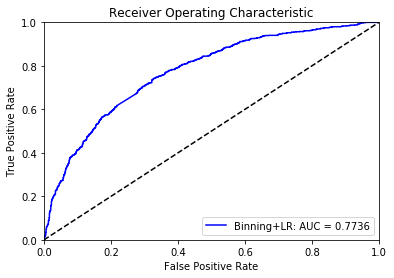

In [15]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='Binning+LR: AUC = {0:.4f}'.format(roc_auc1))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Finally, let's check the piecewise continuous binning for one of the variables with more importance.

In [16]:
optb = binning_process.get_binned_variable("ExternalRiskEstimate")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,c0,c1
0,"[-inf, 63.50)",2213,0.264491,510,1703,0.799992,-0.000000
1,"[63.50, 65.50)",563,0.067288,153,410,4.297026,-0.055071
2,"[65.50, 67.50)",516,0.061671,157,359,1.785820,-0.016732
3,"[67.50, 70.50)",824,0.098482,307,517,2.741859,-0.030896
4,"[70.50, 72.50)",530,0.063344,258,272,2.295898,-0.024570
5,"[72.50, 74.50)",530,0.063344,265,265,2.285759,-0.024430
6,"[74.50, 77.50)",709,0.084738,423,286,3.568860,-0.041653
7,"[77.50, 81.50)",864,0.103263,600,264,1.746868,-0.018144
8,"[81.50, 84.50)",602,0.071949,461,141,2.452263,-0.026799
9,"[84.50, 87.50)",518,0.061910,437,81,1.635269,-0.017130


In [17]:
optb.binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.49858632
    IV (Jeffrey)             1.02947578
    JS (Jensen-Shannon)      0.11880544
    Hellinger                0.12345593
    Triangular               0.44355311
    KS                       0.40217895
    Avg precision            0.69910615
    Brier score              0.19906996
    HHI                      0.12640619
    HHI (normalized)         0.05360671
    Cramer's V               0.45085066
    Quality score            0.01103754

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1     4.273551 0.038710  0.979402  0.020598
        1      2     1.388516 0.238656  0.880875  0.119125
        2      3     6.506519 0.010748  0.995084  0.004916
        3      4    17.292596 0.000032  0.999996  0.000004
        4      5     0.184590 0.667458  0.66

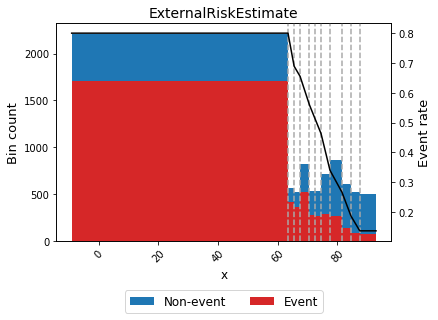

In [18]:
optb.binning_table.plot(metric="event_rate")